<a href="https://colab.research.google.com/github/rridss/Pattern-Recognition/blob/main/realvsfakeface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpmig
import numpy as np
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_train = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/tmp') #Extracts the files into the /tmp folder of colab
zip_train.close()

In [ ]:
train_fake= os.path.join('/tmp/real_and_fake_face/training_fake')
train_real= os.path.join('/tmp/real_and_fake_face/training_real')
real_names= os.listdir(train_real)
print(real_names[:5])
fake_names= os.listdir(train_fake)
print(fake_names[:5])
print('total real images:', len(real_names))
print('total fake images:', len(fake_names))

['real_00100.jpg', 'real_00234.jpg', 'real_00158.jpg', 'real_00849.jpg', 'real_00920.jpg']
['mid_245_1100.jpg', 'mid_250_1111.jpg', 'mid_84_1111.jpg', 'hard_2_1111.jpg', 'mid_246_0011.jpg']
total real images: 1081
total fake images: 960


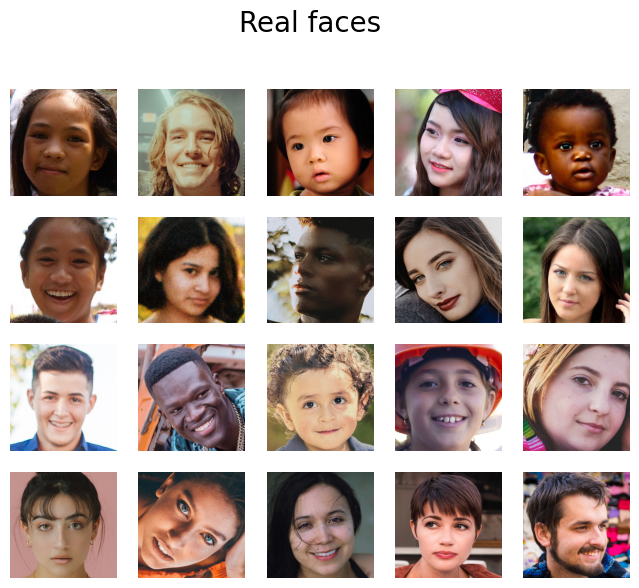

In [ ]:
#DATA VISUALIZATION
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    plt.subplot(5,5, i+1)
    image = cv2.imread(os.path.join(train_real,real_names[i]))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')
plt.show()

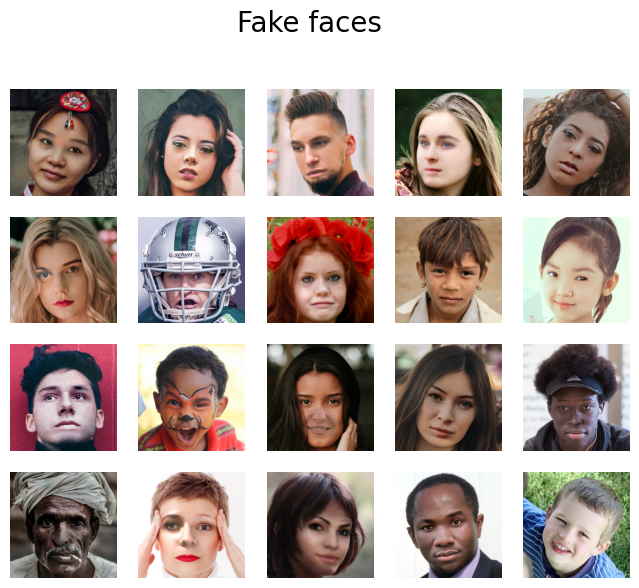

In [ ]:
fig = plt.figure(figsize=(8, 8))
for j in range(20):
    plt.subplot(5,5, j+1)
    image2 = cv2.imread(os.path.join(train_fake,fake_names[j]))
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    plt.imshow(image2_rgb)
    plt.suptitle("Fake faces",fontsize=20)
    plt.axis('off')
plt.show()

In [ ]:
#creating training data for binary classification of images
from random import shuffle
from tqdm import tqdm         #taqaddum shows progress bars
img_size = int(128)
def create_training_data():
   training_data=[]

    # Iterate over real_path images
   for img in  tqdm(real_names[:981]):
        path = os.path.join(train_real,img)
        label = [1]  # Real class label
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size, img_size))
        training_data.append([np.array(image), np.array(label)])
   # Iterate over fake_path images
   for img in tqdm(fake_names[:860]):
        path = os.path.join(train_fake, img)
        label = [0]
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])
   shuffle(training_data) #shuffle data for more variability in training set
   return(training_data)

# CREATING TESTING DATA
def create_test_data():
  test_data= []

  for img in tqdm(real_names[981:]):
    path= os.path.join(train_real,img)
    label= [1]
    image= cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size,img_size))
    test_data.append([np.array(image), np.array(label)])

  for img in tqdm(fake_names[860:]):
    path= os.path.join(train_fake,img)
    label=[0]
    image= cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(img_size,img_size))
    test_data.append([np.array(image), np.array(label)])

  shuffle(test_data) #shuffle data for more variability in training set
  return(test_data)

train_data = create_training_data()
testing_data= create_test_data()

100%|██████████| 100/100 [00:00<00:00, 128.59it/s]


In [ ]:
#semantic reshaping of data to feed into model
#separating labels, and features into X and y

X = []
y = []

for i in train_data:
    X.append(i[0])
    y.append(i[1])

# print(X[0].reshape(-1, 50, 50, 1))
X = np.array(X).reshape(-1, img_size, img_size, 1)

#divide by 255 to squish values to 0 - 1
X = X/255.0
y = np.array(y)

#we made X and y np arrays to be able to feed into the model

print(X.shape[1:])
print(X.shape[:])
#checking shape of array to confirm
print(len(y))

(128, 128, 1)
(1841, 128, 128, 1)
1841


In [ ]:
model = Sequential()
model.add(Conv2D(128,(3,3), input_shape=X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(.5))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))

model.add(Dense(1))
model.add(Activation("sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

model.fit(X, y, batch_size = 50, epochs = 2, verbose = 1, validation_split = 0.2)

print('test')
print(model.weights)
print(len(model.weights))

Epoch 1/2
30/30 [==============================] - 95s 3s/step - loss: 0.6949 - accuracy: 0.5136 - val_loss: 0.6911 - val_accuracy: 0.5339
Epoch 2/2
30/30 [==============================] - 93s 3s/step - loss: 0.6951 - accuracy: 0.5279 - val_loss: 0.6918 - val_accuracy: 0.5339
test
[<tf.Variable 'conv2d_12/kernel:0' shape=(3, 3, 1, 128) dtype=float32, numpy=
array([[[[ 0.04941864,  0.03648503, -0.06259249, ..., -0.06554335,
          -0.01448449,  0.03403136]],

        [[-0.02267454,  0.02467432,  0.04137411, ...,  0.0391164 ,
          -0.00421992, -0.01437302]],

        [[ 0.06126913,  0.05976032, -0.03656761, ...,  0.04460817,
          -0.03328007, -0.01679827]]],


       [[[ 0.0623479 , -0.03764622, -0.06414698, ...,  0.04170814,
           0.02813559, -0.05861021]],

        [[-0.03597478, -0.05883004,  0.00897605, ..., -0.04570682,
           0.04306335,  0.06705657]],

        [[ 0.00608515, -0.00117916, -0.02900019, ...,  0.01323538,
          -0.04154315,  0.01151618]]],

